<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/Anomaly_detection_using_autoencoders_part2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras_preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pickle

import pandas as pd
import seaborn as sns
import cv2

In [ ]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# minimize the data and reshape it to 128*128*1
a_file = open('/content/drive/MyDrive/Colab Notebooks/data_of_502_images(128).pkl', 'rb')
file_pic = pickle.load(a_file)

img_array = np.array(list(file_pic.values()))
img_array = img_array.astype('float32') / 255.
img_array = np.reshape(img_array, (len(img_array), 128, 128, 1))

x_train = img_array[:2000]
x_test = img_array[2000:]

In [ ]:
# Size of input image
Size = 128

In [ ]:
# Encoder
model = Sequential()

model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(Size, Size, 1)))

model.add(Conv2D(16, (5, 5), activation='relu', padding='same', strides = 2))

model.add(Conv2D(8, (5, 5), activation='relu', padding='same'))


#Decoder
model.add(Conv2DTranspose(8, (5, 5), activation='relu', padding='same'))

model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same', strides = 2))

model.add(Conv2DTranspose(24, (5, 5), activation='relu', padding='same'))


In [ ]:
# # custom mse loss fuction with average brightness effect
# def mse(y_true, y_pred):
#   mse = tf.reduce_mean(tf.square(tf.math.subtract(y_true, y_pred)))
#   brightness_average = tf.math.reduce_mean(y_pred, axis = (1, 2, 3))
#   return mse * (2 * tf.reduce_mean(brightness_average))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

# training of model using mean squared error as a loss function
model.add(Conv2D(1, (5, 5), activation = 'sigmoid', padding = 'same'))     

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])     # compiling using MSE loss

model.summary()  # model summary

#Fit the model. 
history = model.fit(
        x_train, x_train,
        batch_size = 32,
        epochs=30,
        shuffle=True, callbacks=[callback],
        validation_data=(x_test, x_test))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 24)      624       
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 16)        9616      
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 8)         3208      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 64, 64, 8)        1608      
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 128, 128, 16)     3216      
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 128, 128, 24)    

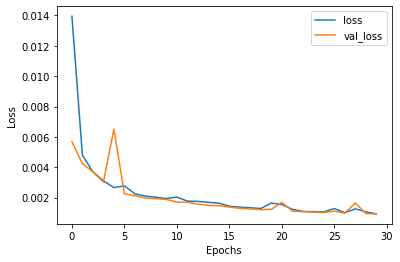

In [ ]:
# train and val loss using mse
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# # store the train model into pickle file
# a_file = open("/content/drive/MyDrive/Colab Notebooks/model_with_sigmoid_without_maxpooling_try_13.07.pkl", "wb")
# pickle.dump(model, a_file)
# a_file.close()

In [ ]:
# caclulating reconstruction error for model trained using mse loss
reconstruction = model.predict(x_test)
test_loss = tf.keras.losses.mse(reconstruction, x_test)

In [ ]:
# calculating loss for test images
loss_ls = []
for i in range(0, len(x_test)):
  score = model.evaluate(reconstruction[i], x_test[i])
  loss_ls.append(score[0])

loss_df = pd.DataFrame(loss_ls, columns = ['Loss']) 

smallest_loss = loss_df.nsmallest(5, columns = ['Loss'])
largest_loss = loss_df.nlargest(5, columns = ['Loss'])

min_index_ls = smallest_loss.index.tolist()
min_loss = smallest_loss.Loss.tolist()

max_index_ls = largest_loss.index.tolist()
max_loss = largest_loss.Loss.tolist()

In [ ]:
print("min loss index", min_index_ls)
print("max_loss_index", max_index_ls)

min loss index [295, 110, 340, 115, 445]
max_loss_index [159, 433, 431, 46, 89]


In [ ]:
print(model.evaluate(reconstruction, x_test))
print(model.evaluate(x_test, x_test))

16/16 [==============================] - 0s 21ms/step - loss: 0.0012 - mse: 0.0012
[0.0012163313804194331, 0.0012163313804194331]
16/16 [==============================] - 0s 17ms/step - loss: 9.2717e-04 - mse: 9.2717e-04
[0.0009271677117794752, 0.0009271677117794752]


In [ ]:
# dumy_loss = loss_df[loss_df['Loss'] > 0.075]
# dumy_small = dumy_loss.nsmallest(5, columns = ['Loss'])
# chk_index, chk_loss_val = dumy_small.index.tolist(), dumy_small.Loss.tolist()

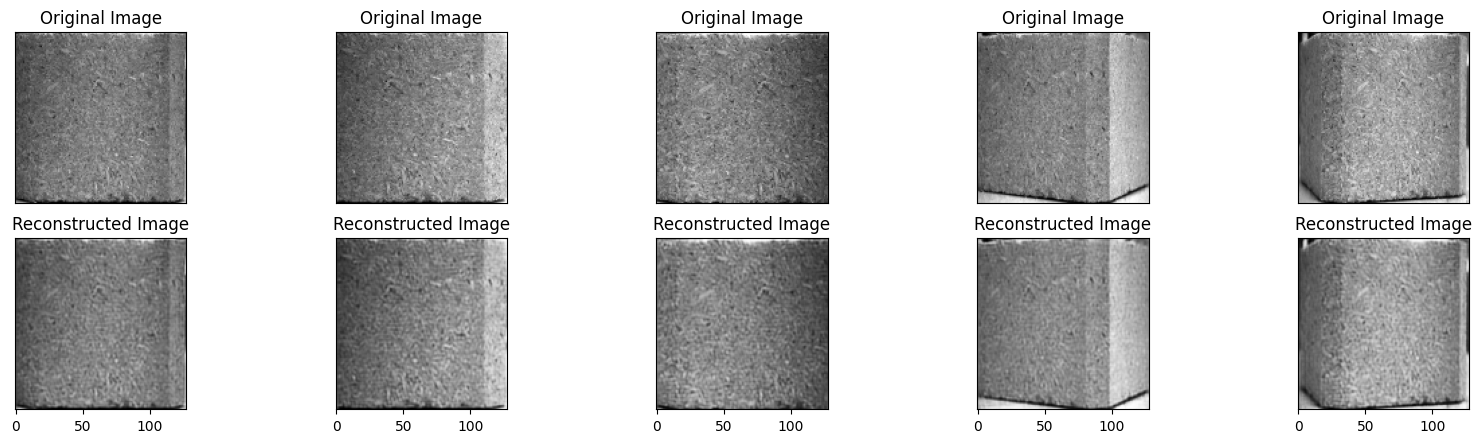

In [ ]:
# 5 orignal images and their reconstruction where the loss is minimum
n = 5
plt.figure(figsize=(20, 5), dpi=100)
for i in range(0, n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(reconstruction[i].reshape(128, 128))
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
    label = 'Loss: {:.3f}'
    # ax.set_xlabel(label.format(chk_loss_val[i]) )
    
plt.show()

In [ ]:
# tf.RaggedTensor.from_tensor(x_test[0].reshape(132, 132), padding=-1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


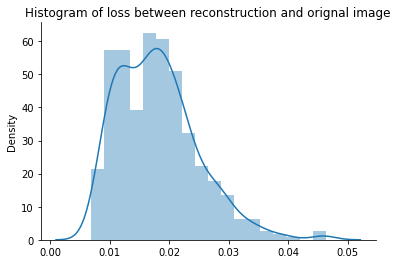

In [ ]:
ax = sns.distplot(loss_ls)
ax.set_title('Histogram of loss between reconstruction and orignal image')
sns.despine()

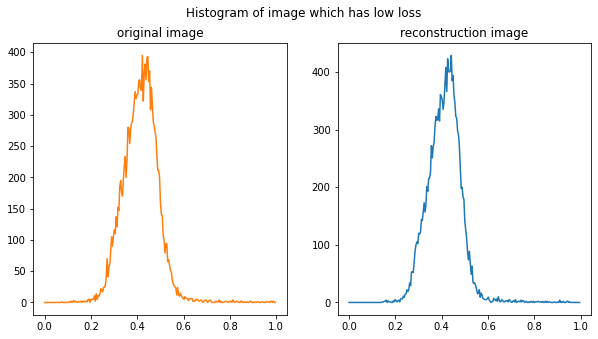

In [ ]:
# histogram_1, bin_edges_1 = np.histogram(x_test[min_index_ls[0]].reshape(132,132), bins=256, range=(0, 1))
# histogram, bin_edges = np.histogram(reconstruction[min_index_ls[0]].reshape(132,132), bins=256, range=(0, 1))

histogram_1, bin_edges_1 = np.histogram(x_test[min_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(reconstruction[min_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))


fig = plt.figure(figsize=(10,5))
fig.suptitle('Histogram of image which has low loss')
axes = fig.subplots(1, 2)

axes[0].plot(bin_edges_1[0:-1], histogram_1, 'tab:orange')
axes[0].set_title('original image')
axes[1].plot(bin_edges[0:-1], histogram)
axes[1].set_title('reconstruction image')

plt.show()

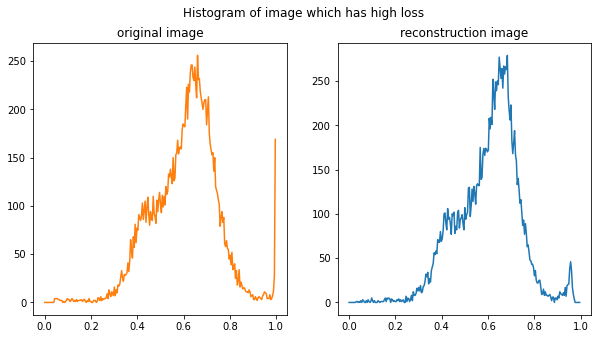

In [ ]:
# histogram_1, bin_edges_1 = np.histogram(x_test[max_index_ls[0]].reshape(132,132), bins=256, range=(0, 1))
# histogram, bin_edges = np.histogram(reconstruction[max_index_ls[0]].reshape(132,132), bins=256, range=(0, 1))

histogram_1, bin_edges_1 = np.histogram(x_test[max_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(reconstruction[max_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))


fig = plt.figure(figsize=(10,5))
fig.suptitle('Histogram of image which has high loss')
axes = fig.subplots(1, 2)

axes[0].plot(bin_edges_1[0:-1], histogram_1, 'tab:orange')
axes[0].set_title('original image')
axes[1].plot(bin_edges[0:-1], histogram)
axes[1].set_title('reconstruction image')

plt.show()

In [ ]:
# x_test[min_index_ls[1]][np.where(x_test[min_index_ls[1]])]

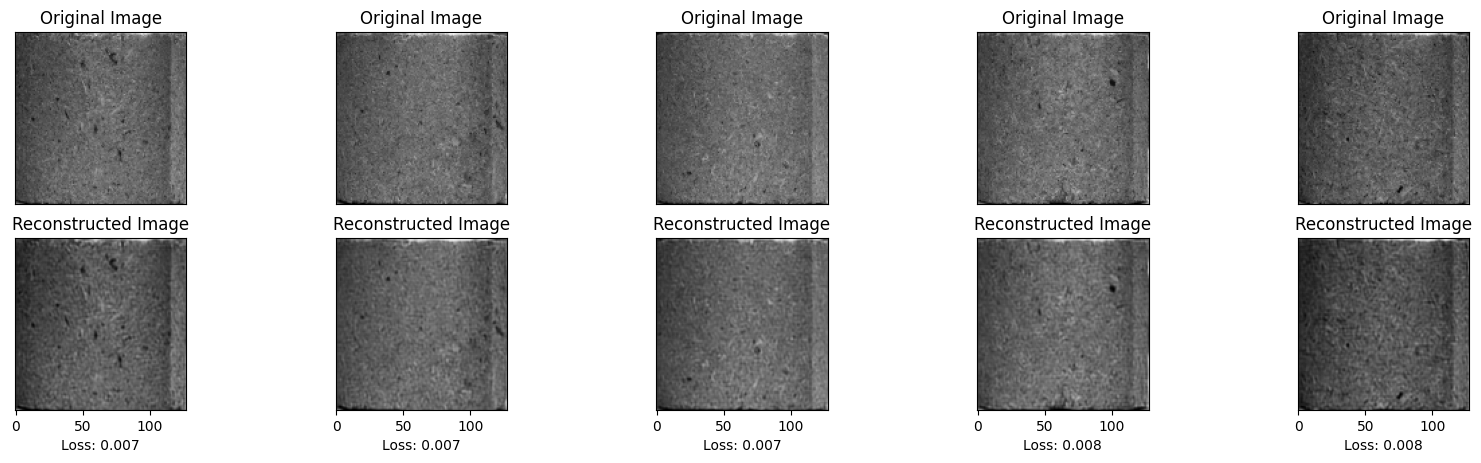

In [ ]:
# 5 orignal images and their reconstruction where the loss is minimum
n = 5
plt.figure(figsize=(20, 5), dpi=100)
for i in range(0, n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[min_index_ls[i]].reshape(Size, Size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(reconstruction[min_index_ls[i]].reshape(Size, Size))
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
    label = 'Loss: {:.3f}'
    ax.set_xlabel(label.format(min_loss[i]))
    
plt.show()

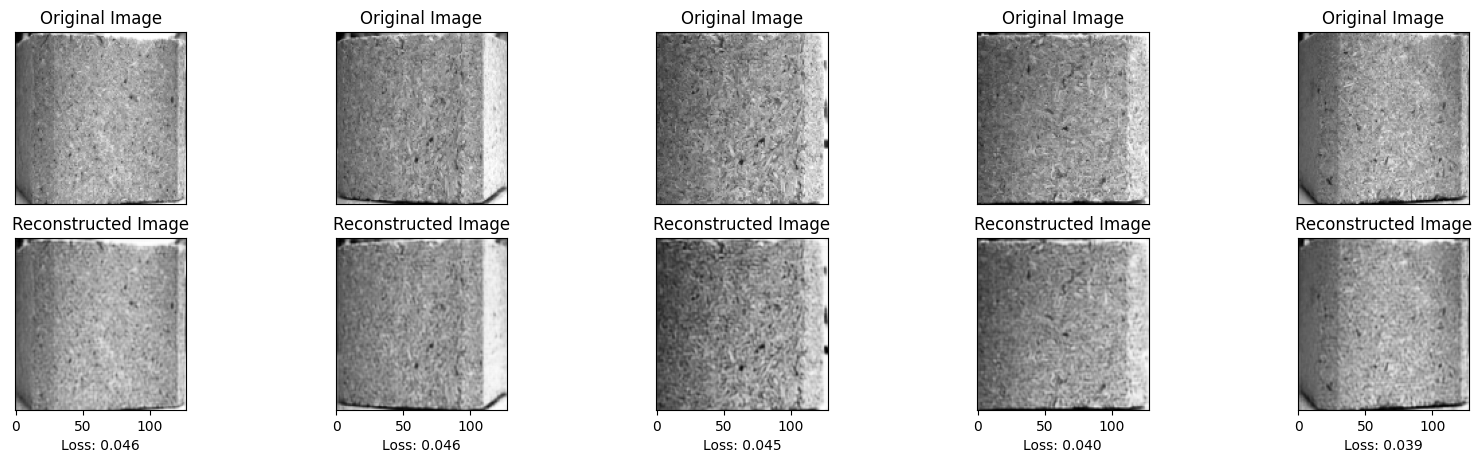

In [ ]:
# orignal images and their reconstruction where the loss is high
n = 5
plt.figure(figsize=(20, 5), dpi=100)
for i in range(0, n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[max_index_ls[i]].reshape(Size, Size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.title("Reconstructed")
    plt.imshow(reconstruction[max_index_ls[i]].reshape(Size, Size))
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
    label = 'Loss: {:.3f}'
    ax.set_xlabel(label.format(max_loss[i]) )
    
plt.show()

In [ ]:
# range of values are changing (after training it) 